<a href="https://colab.research.google.com/github/satvik-dixit/explainability_ICASSP_2024/blob/main/Explainability_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability of DL-based embeddings




### Importing packages

In [1]:

!git clone -q https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -q -e ./serab-byols

!pip install -q tqdm==4.60.0
!pip install -q opensmile
!pip install -q lofo-importance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 848.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# code to restart runtime so the packages get installed
import os
os.kill(os.getpid(), 9)

In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import random
import torch
import opensmile
import serab_byols
import seaborn as sns

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, f1_score, make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
f1 = make_scorer(f1_score, average='weighted')

from lofo import LOFOImportance, Dataset, plot_importance
from lofo.flofo_importance import FLOFOImportance

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Upload kaggle.json to download the EmoDB dataset

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [3]:
np.random.seed(42)

# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_files: string
      The paths of the wav files
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))

  return audio_list


### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [4]:
# Load dataset
! kaggle datasets download -q -d piyushagni5/berlin-database-of-emotional-speech-emodb
! unzip -q berlin-database-of-emotional-speech-emodb.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/wav','*.wav'))
audio_list = load_audio_files(audio_files, resampling_frequency=16000)

# Making speakers list and labels list
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:2]))
  labels.append(file_name[5:6])

label_dict = {'A': 'fear', 'L': 'boredom', 'E': 'disgust', 'T': 'sadness', 'W': 'anger', 'N': 'neutrality', 'F': 'joy'}
labels = [label_dict[emotion] for emotion in labels]

# Verify
# print(speakers)
# print(labels)

print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))


Number of audio files: 535
Number of speaker classes: 10
Speaker classes: {3, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Number of speakers: 535
Number of label classes: 7
Label classes: {'anger', 'joy', 'boredom', 'sadness', 'neutrality', 'disgust', 'fear'}
Number of labels: 535


## Embedding Extraction
Includes extracting features using
- Deep learning based methods: Hybrid BYOL-S
- DSP based methods: openSMILE eGeMAPS

### Audio embeddings extraction functions

In [5]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
  '''
  Generates model for embedding extraction

  Parameters
  ------------
  mode_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

  Returns
  ------------
  model: object
      The embedding extraction model
  '''
  if model_name=='hybrid_byols':
    model_name = 'cvt'
    checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
    model = serab_byols.load_model(checkpoint_path, model_name)
  elif model_name=='compare':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  elif model_name=='egemaps':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_list: list
      A list of arrays, one array for each audio file
  model_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
  model: object
      The embedding extraction model generated by audio_embeddings_model function
  sampling_rate: int
      The sampling rate, 16 kHz by default

  Returns
  ------------
  embeddings_array: array
      The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)

  '''
  if model_name=='hybrid_byols':
    embeddings_array = serab_byols.get_scene_embeddings(audio_list, model)
  else:
    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
      embeddings = model.process_signal(audio_list[i], sampling_rate)
      embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
  return embeddings_array


def get_egemaps_feature_names():
  model = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  egemaps_feature_names = model.column_names
  return egemaps_feature_names



### Audio embeddings extraction on EmoDB

In [6]:

# Hybrid BYOLS
model = audio_embeddings_model(model_name='hybrid_byols')
embeddings_array_byols = audio_embeddings(audio_list, model_name='hybrid_byols', model=model)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

egemaps_feature_names = get_egemaps_feature_names()

# Verify Phase_2
models = ['hybrid_byols', 'egemaps']
embeddings_arrays = {'hybrid_byols': embeddings_array_byols, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))
  # print('The embeddings array is: ')
  # print((embeddings_arrays[model]))


100%|██████████| 535/535 [01:36<00:00,  5.52it/s]




MODEL: hybrid_byols

The shape of the embeddings array is torch.Size([535, 2048])


MODEL: egemaps

The shape of the embeddings array is torch.Size([535, 88])


## Classification and Feature Importance Functions


In [7]:
# function for dividing the dataset into dictionaries with emotions as keys and embeddings/labels/speakers as values

def label_division(embeddings_array, labels, required_labels, speakers):
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [8]:
# function for combining one emotion (50%) and the rest of the 5 emotions (10% each)

def emotion_all_merger(emotion, other_emotions, embeddings_dict, speakers_dict, num=45):

  np.random.seed(42)

  emo_indices = np.random.choice(len(speakers_dict[emotion]), size=num, replace=False)

  embeddings = embeddings_dict[emotion][emo_indices]
  speakers = [speakers_dict[emotion][i] for i in emo_indices]
  labels = [1]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(speakers_dict[em]), size=int(num/len(other_emotions)), replace=False)
    em_speakers = [speakers_dict[em][i] for i in em_indices]
    embeddings_e = embeddings_dict[em][em_indices]

    embeddings = np.concatenate((embeddings, embeddings_e), axis=0)
    speakers = speakers + em_speakers
    labels = labels + [0]*int(num/len(other_emotions))

  return embeddings, labels, speakers


In [10]:
# Function for ranking all features in decreasing order of feature importance using coefficients

def feature_importance_method(X, y, feature_names, trained_model):
  coef_abs = abs(trained_model.coef_[0])
  feature_indices = np.argsort(coef_abs)[::-1]
  sorted_importances = [(feature_names[i], coef_abs[i]) for i in feature_indices]
  return sorted_importances


In [11]:
# Function for nested cross validation

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
Performance ={'eGeMAPS':{e:[] for e in emotions}, 'Hybrid_BYOL-S_2048':{e:[] for e in emotions}, 'Hybrid_BYOL-S_top_features':{e:[] for e in emotions}}

def classification_pipeline(embeddings, speakers, labels_list, feature_names):

    np.random.seed(42)

    X = embeddings
    y = labels_list
    groups = speakers

    # Define the hyperparameter grid for GridSearchCV
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Outer cross-validation loop
    outer_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
    outer_scores = []
    feats_array = []
    for train_index, test_index in outer_cv.split(X, y, groups):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
        grid_search = GridSearchCV(LogisticRegression(solver='lbfgs', penalty='l2'), param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train, groups=[groups[i] for i in train_index])

        # Get the best hyperparameters found in the inner loop
        best_params = grid_search.best_params_

        # Fit the model with the best hyperparameters on the training data
        model = LogisticRegression(solver='lbfgs', penalty='l2', **best_params)

        # Standardize X_train and transform X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='binary') # change to binary
        outer_scores.append(score)

    # Compute and print the mean F1 score across all outer folds
    mean_f1 = np.round(100*np.mean(outer_scores), 1)
    return model, mean_f1



In [12]:
def find_x_at_n_percentile(x_values, y_values, n):
    percentile = np.percentile(y_values, n)
    for i, y in enumerate(y_values):
        if y >= percentile:
            x_at_nth_percentile = x_values[i]
            break

    return x_at_nth_percentile

# eGeMAPS

In [13]:
eGeMAPS_embeddings_dict, eGeMAPS_labels_dict, eGeMAPS_speakers_list_dict = label_division(embeddings_array=embeddings_array_egemaps, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)


In [14]:
eGeMAPS_fi_dict = {}
egemaps_top_features_df = {}

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  ege_embeddings, ege_labels, ege_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=45)

  trained_model, result = classification_pipeline(embeddings=ege_embeddings, speakers=ege_speakers, labels_list=ege_labels, feature_names=egemaps_feature_names)
  Performance['eGeMAPS'][e] = result

  fi = feature_importance_method(X=ege_embeddings, y=ege_labels, feature_names=egemaps_feature_names, trained_model=trained_model)
  eGeMAPS_fi_dict[e] = [list(egemaps_feature_names).index(tup[0]) for tup in fi]
  eGeMAPS_top_fi_features = [[tup[0], np.round(tup[1], 3)] for tup in fi]
  table = {'Feature': [element[0] for element in eGeMAPS_top_fi_features], 'Importance': [element[1] for element in eGeMAPS_top_fi_features]}
  egemaps_top_features_df[e] = pd.DataFrame(table)


## Most important egemaps features (according to coef)

In [15]:
df = egemaps_top_features_df[emotions[0]]
df.head(10)


,Feature,Importance
0,slopeUV0-500_sma3nz_amean,1.734
1,HNRdBACF_sma3nz_amean,1.184
2,mfcc3_sma3_amean,1.087
3,shimmerLocaldB_sma3nz_stddevNorm,1.078
4,F2bandwidth_sma3nz_stddevNorm,1.057
5,slopeV0-500_sma3nz_amean,1.017
6,mfcc3_sma3_stddevNorm,0.973
7,alphaRatioV_sma3nz_amean,0.971
8,mfcc1_sma3_stddevNorm,0.944
9,mfcc1V_sma3nz_stddevNorm,0.899


In [16]:
df = egemaps_top_features_df[emotions[1]]
df.head(10)


,Feature,Importance
0,shimmerLocaldB_sma3nz_stddevNorm,2.375
1,F3frequency_sma3nz_stddevNorm,1.486
2,logRelF0-H1-H2_sma3nz_amean,1.330
3,MeanUnvoicedSegmentLength,1.235
4,slopeUV0-500_sma3nz_amean,1.186
5,hammarbergIndexV_sma3nz_stddevNorm,1.176
6,HNRdBACF_sma3nz_amean,1.169
7,loudness_sma3_meanFallingSlope,1.166
8,spectralFluxV_sma3nz_amean,1.116
9,HNRdBACF_sma3nz_stddevNorm,1.071


In [17]:
df = egemaps_top_features_df[emotions[2]]
df.head(10)


,Feature,Importance
0,loudnessPeaksPerSec,1.299
1,jitterLocal_sma3nz_amean,1.205
2,StddevUnvoicedSegmentLength,1.112
3,mfcc4_sma3_amean,0.929
4,mfcc2V_sma3nz_stddevNorm,0.855
5,mfcc1_sma3_amean,0.839
6,mfcc3_sma3_amean,0.808
7,mfcc4V_sma3nz_amean,0.783
8,F3frequency_sma3nz_stddevNorm,0.714
9,mfcc3V_sma3nz_amean,0.706


In [18]:
df = egemaps_top_features_df[emotions[3]]
df.head(10)


,Feature,Importance
0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.116
1,mfcc3V_sma3nz_amean,0.086
2,mfcc3_sma3_amean,0.075
3,F3bandwidth_sma3nz_stddevNorm,0.072
4,loudness_sma3_percentile50.0,0.067
5,MeanUnvoicedSegmentLength,0.067
6,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.066
7,mfcc3V_sma3nz_stddevNorm,0.058
8,StddevUnvoicedSegmentLength,0.057
9,loudness_sma3_stddevNorm,0.056


In [19]:
df = egemaps_top_features_df[emotions[4]]
df.head(10)


,Feature,Importance
0,VoicedSegmentsPerSec,1.043
1,MeanUnvoicedSegmentLength,0.959
2,StddevUnvoicedSegmentLength,0.934
3,hammarbergIndexV_sma3nz_amean,0.754
4,mfcc3V_sma3nz_amean,0.684
5,StddevVoicedSegmentLengthSec,0.680
6,F3frequency_sma3nz_amean,0.667
7,mfcc4V_sma3nz_amean,0.639
8,slopeV0-500_sma3nz_amean,0.636
9,mfcc2V_sma3nz_stddevNorm,0.625


In [20]:
df = egemaps_top_features_df[emotions[5]]
df.head(10)


,Feature,Importance
0,loudnessPeaksPerSec,0.823
1,slopeV0-500_sma3nz_amean,0.819
2,loudness_sma3_pctlrange0-2,0.626
3,mfcc3_sma3_stddevNorm,0.617
4,mfcc4_sma3_amean,0.564
5,logRelF0-H1-A3_sma3nz_amean,0.556
6,loudness_sma3_percentile50.0,0.531
7,F1bandwidth_sma3nz_amean,0.524
8,loudness_sma3_stddevFallingSlope,0.524
9,F1frequency_sma3nz_amean,0.515


# Hybrid BYOL-S

In [26]:
byols_embeddings_dict, byols_labels_dict, byols_speakers_list_dict = label_division(embeddings_array=embeddings_array_byols, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)


In [27]:
byols_feature_names = [i for i in range(2048)]
byols_fi_dict = {}
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  byols_embeddings, byols_labels, byols_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=byols_embeddings_dict, speakers_dict=byols_speakers_list_dict, num=45)

  trained_model, result = classification_pipeline(embeddings=byols_embeddings, speakers=byols_speakers, labels_list=byols_labels, feature_names=byols_feature_names)
  Performance['Hybrid_BYOL-S_2048'][e] = result

  fi = feature_importance_method(X=byols_embeddings, y=byols_labels, feature_names=byols_feature_names, trained_model=trained_model)
  byols_fi_dict[e] = [tup[0] for tup in fi]


In [56]:
num_byols_features = {e: 1 for e in emotions}

def plot_top_performance(e, importance_dict):
  byols_embeddings, byols_labels, byols_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=byols_embeddings_dict, speakers_dict=byols_speakers_list_dict, num=45)
  top_scores = []
  bottom_scores = []
  rest_scores = []

  for n in range(10, 1024, 10):

    top_features = importance_dict[e][:n]
    best_model, top_f1 = classification_pipeline(embeddings=byols_embeddings[:, top_features], speakers=byols_speakers, labels_list=byols_labels, feature_names=byols_feature_names)
    top_scores.append(top_f1)

    rest_features = importance_dict[e][n+1:]
    best_model, rest_f1 = classification_pipeline(embeddings=byols_embeddings[:, rest_features], speakers=byols_speakers, labels_list=byols_labels, feature_names=byols_feature_names)
    rest_scores.append(rest_f1)

    bottom_features = importance_dict[e][2048-n-1:]
    best_model, bottom_f1 = classification_pipeline(embeddings=byols_embeddings[:, bottom_features], speakers=byols_speakers, labels_list=byols_labels, feature_names=byols_feature_names)
    bottom_scores.append(bottom_f1)

  n_features = range(10, 1024, 10)
  fig, ax = plt.subplots()

  ax.plot(n_features, top_scores, label='Top dimensions')
  ax.plot(n_features, rest_scores, label='Rest dimensions')
  ax.plot(n_features, bottom_scores, label='Bottom dimensions')

  ax.set_xlabel('Number of dimensions')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()

  percentile = np.percentile(top_scores, 100)
  # ax.axhline(y=percentile, color='r')

  ax.set_ylim(0, 100)
  x_val = find_x_at_n_percentile(n_features, top_scores, 100)
  ax.scatter(x_val, percentile, marker='x', color='red')

  return x_val, percentile



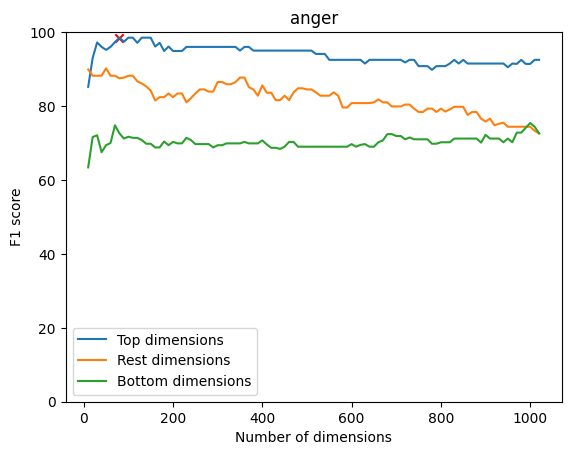

In [57]:
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

num_byols_features[emotions[0]], Performance['Hybrid_BYOL-S_top_features'][emotions[0]] = plot_top_performance(emotions[0], byols_fi_dict)


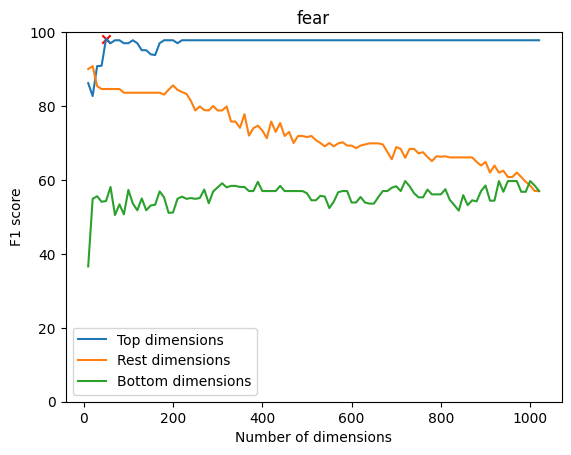

In [58]:

num_byols_features[emotions[1]], Performance['Hybrid_BYOL-S_top_features'][emotions[1]]  = plot_top_performance(emotions[1], byols_fi_dict)


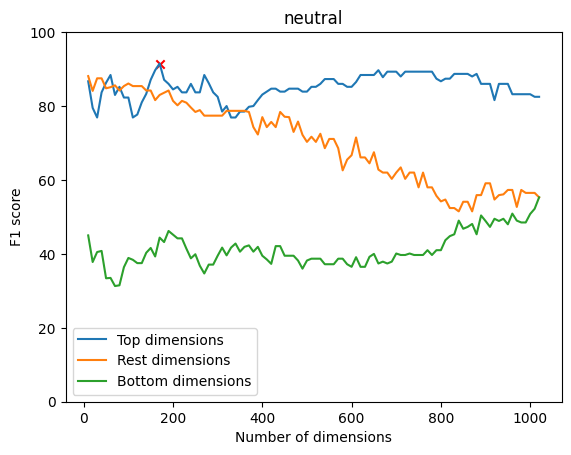

In [59]:

num_byols_features[emotions[2]], Performance['Hybrid_BYOL-S_top_features'][emotions[2]] = plot_top_performance(emotions[2], byols_fi_dict)


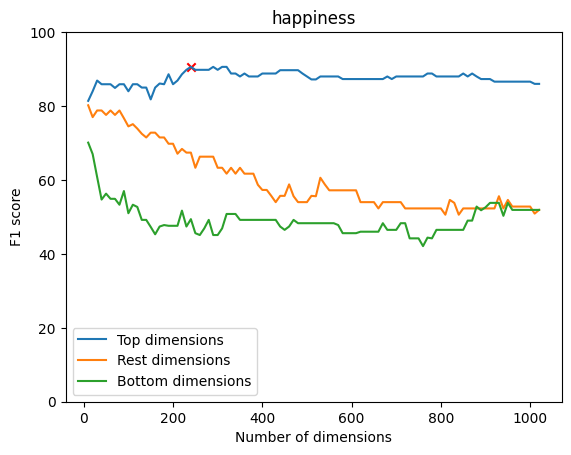

In [60]:

num_byols_features[emotions[3]], Performance['Hybrid_BYOL-S_top_features'][emotions[3]] = plot_top_performance(emotions[3], byols_fi_dict)


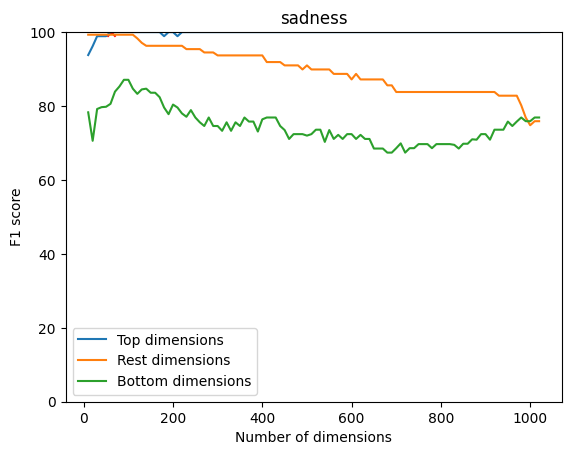

In [61]:

num_byols_features[emotions[4]], Performance['Hybrid_BYOL-S_top_features'][emotions[4]] = plot_top_performance(emotions[4], byols_fi_dict)


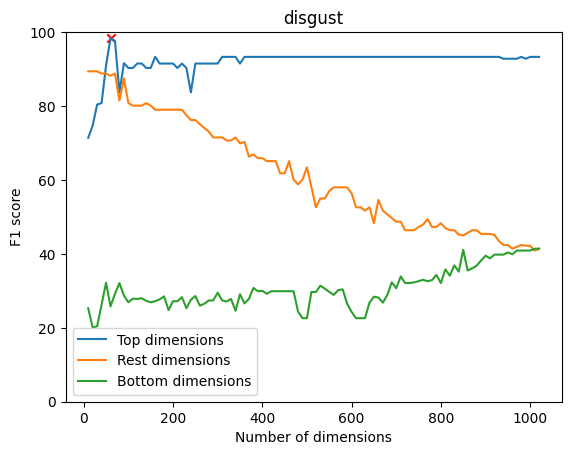

In [62]:

num_byols_features[emotions[5]], Performance['Hybrid_BYOL-S_top_features'][emotions[5]] = plot_top_performance(emotions[5], byols_fi_dict)


In [63]:
print(num_byols_features)


{'anger': 80, 'fear': 50, 'neutral': 170, 'happiness': 240, 'sadness': 60, 'disgust': 60}


In [21]:
num_byols_features = {'anger': 80, 'fear': 50, 'neutrality': 170, 'joy': 240, 'sadness': 60, 'disgust': 60}

# Predicting Functions

In [22]:
# Defining a function for all steps
from sklearn.linear_model import Ridge

def prediction_pipeline(labeled_array, labels_list, regression_model, scoring='neg_root_mean_squared_error'):

  X_train, X_test, y_train, y_test = train_test_split(labeled_array, labels_list, test_size=0.20)

  if regression_model == 'ridge':
    regressor = Ridge()
    parameters = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    result, p = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  return result, p


In [23]:

# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring='neg_mean_squared_error'): # check scoring
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
    The labels that will be used for training
  y_test: list
    The labels that will be used for testing
  classifier: object
    The instance of the classification model
  parameters: dictionary
    The dictionary of parameters for GridSearchCV

  Returns
  ------------
    The dictionary of the best hyperparameters

  '''

  # Define the pipeline
  pipe = Pipeline([
          ('scaler', StandardScaler()),
          ('model', regressor)
      ])

  grid = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
  grid.fit(X_train, y_train)

  y_pred = grid.predict(X_test)
  r_squared = r2_score(y_test, y_pred)
  pearson_correlation = np.corrcoef(y_test, y_pred)[0, 1]

  return r_squared, pearson_correlation

# Getting performance for top features

In [24]:
predicted_df_dict = {}

def top_byols_predict_ege(e):

  en_errors_r_squared_top = []
  en_errors_r_squared_all = []
  pearson_corr_top = []
  pearson_corr_all = []

  byols_embeddings, byols_labels, byols_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=byols_embeddings_dict, speakers_dict=byols_speakers_list_dict, num=45)
  ege_embeddings, ege_labels, ege_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=45)

  top_features = byols_fi_dict[e][:num_byols_features[e]]
  all_features = byols_fi_dict[e][:]


  for i in tqdm(range(88)):

    en_r_squared_top, p_corr_top = prediction_pipeline(byols_embeddings[:, top_features], ege_embeddings[:,i], regression_model='ridge')
    en_errors_r_squared_top.append(np.round(en_r_squared_top, 3))
    pearson_corr_top.append(np.round(p_corr_top, 3))

    en_r_squared_all, p_corr_all = prediction_pipeline(byols_embeddings[:, all_features], ege_embeddings[:,i], regression_model='ridge')
    en_errors_r_squared_all.append(np.round(en_r_squared_all, 3))
    pearson_corr_all.append(np.round(p_corr_all, 3))

  prediction_metrics_dict = {'Feature':egemaps_feature_names, 'Pearson top':pearson_corr_top, 'Pearson all': pearson_corr_all}

  return prediction_metrics_dict


In [28]:
df = pd.DataFrame(top_byols_predict_ege(emotions[0]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[0]] = sorted_df


100%|██████████| 88/88 [00:34<00:00,  2.53it/s]


In [29]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
58,alphaRatioV_sma3nz_amean,0.950,0.939
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.945,0.983
60,hammarbergIndexV_sma3nz_amean,0.932,0.971
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.930,0.985
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.911,0.975
38,logRelF0-H1-A3_sma3nz_amean,0.906,0.921
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.904,0.953
28,mfcc4_sma3_amean,0.892,0.979
70,mfcc2V_sma3nz_amean,0.891,0.977
56,F3amplitudeLogRelF0_sma3nz_amean,0.887,0.941


In [30]:
df = pd.DataFrame(top_byols_predict_ege(emotions[1]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[1]] = sorted_df


100%|██████████| 88/88 [00:33<00:00,  2.62it/s]


In [31]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.916,0.976
36,logRelF0-H1-H2_sma3nz_amean,0.906,0.825
34,HNRdBACF_sma3nz_amean,0.895,0.902
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.890,0.971
28,mfcc4_sma3_amean,0.890,0.952
57,F3amplitudeLogRelF0_sma3nz_stddevNorm,0.888,0.954
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.868,0.919
78,slopeUV0-500_sma3nz_amean,0.863,0.942
62,slopeV0-500_sma3nz_amean,0.862,0.935
24,mfcc2_sma3_amean,0.858,0.979


In [32]:
df = pd.DataFrame(top_byols_predict_ege(emotions[2]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[2]] = sorted_df


100%|██████████| 88/88 [00:38<00:00,  2.31it/s]


In [33]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
24,mfcc2_sma3_amean,0.976,0.963
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.965,0.913
38,logRelF0-H1-A3_sma3nz_amean,0.943,0.911
57,F3amplitudeLogRelF0_sma3nz_stddevNorm,0.941,0.930
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.940,0.979
28,mfcc4_sma3_amean,0.937,0.940
62,slopeV0-500_sma3nz_amean,0.932,0.988
15,loudness_sma3_pctlrange0-2,0.930,0.859
56,F3amplitudeLogRelF0_sma3nz_amean,0.926,0.931
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.924,0.977


In [34]:
df = pd.DataFrame(top_byols_predict_ege(emotions[3]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[3]] = sorted_df


100%|██████████| 88/88 [00:37<00:00,  2.35it/s]


In [35]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.970,0.991
72,mfcc3V_sma3nz_amean,0.961,0.912
70,mfcc2V_sma3nz_amean,0.959,0.978
38,logRelF0-H1-A3_sma3nz_amean,0.957,0.954
56,F3amplitudeLogRelF0_sma3nz_amean,0.956,0.878
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.955,0.986
24,mfcc2_sma3_amean,0.953,0.974
28,mfcc4_sma3_amean,0.952,0.956
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.951,0.982
44,F1amplitudeLogRelF0_sma3nz_amean,0.933,0.916


In [36]:
df = pd.DataFrame(top_byols_predict_ege(emotions[4]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[4]] = sorted_df


100%|██████████| 88/88 [00:34<00:00,  2.52it/s]


In [37]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.967,0.980
68,mfcc1V_sma3nz_amean,0.926,0.957
62,slopeV0-500_sma3nz_amean,0.921,0.973
56,F3amplitudeLogRelF0_sma3nz_amean,0.921,0.977
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.916,0.933
45,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.913,0.935
58,alphaRatioV_sma3nz_amean,0.911,0.943
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.907,0.981
26,mfcc3_sma3_amean,0.904,0.893
60,hammarbergIndexV_sma3nz_amean,0.901,0.918


In [38]:
df = pd.DataFrame(top_byols_predict_ege(emotions[5]))
sorted_df = df.sort_values(by='Pearson top', ascending=False)
predicted_df_dict[emotions[5]] = sorted_df


100%|██████████| 88/88 [00:32<00:00,  2.70it/s]


In [39]:
sorted_df.head(10)

,Feature,Pearson top,Pearson all
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.929,0.984
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.916,0.964
68,mfcc1V_sma3nz_amean,0.916,0.935
74,mfcc4V_sma3nz_amean,0.908,0.838
86,StddevUnvoicedSegmentLength,0.890,0.634
62,slopeV0-500_sma3nz_amean,0.889,0.940
13,loudness_sma3_percentile50.0,0.882,0.871
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.859,0.992
57,F3amplitudeLogRelF0_sma3nz_stddevNorm,0.858,0.931
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.848,0.945


In [67]:
def summary_table(e):
    df1 = egemaps_top_features_df[e]
    df2 = predicted_df_dict[e]
    merged_df = pd.merge(df1, df2, on='Feature', how='inner')
    merged_df['scores'] = merged_df.apply(lambda row: [row['Importance'], row['Pearson top'], row['Pearson all']], axis=1)
    merged_df.drop(['Importance', 'Pearson top', 'Pearson all'], axis=1, inplace=True)
    return merged_df


In [68]:
e = emotions[0]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,slopeUV0-500_sma3nz_amean,"[1.734, 0.823, 0.863]"
1,HNRdBACF_sma3nz_amean,"[1.184, 0.789, 0.91]"
2,mfcc3_sma3_amean,"[1.087, 0.763, 0.94]"
3,shimmerLocaldB_sma3nz_stddevNorm,"[1.078, 0.317, 0.318]"
4,F2bandwidth_sma3nz_stddevNorm,"[1.057, 0.394, 0.3]"
5,slopeV0-500_sma3nz_amean,"[1.017, 0.869, 0.987]"
6,mfcc3_sma3_stddevNorm,"[0.973, 0.082, -0.063]"
7,alphaRatioV_sma3nz_amean,"[0.971, 0.95, 0.939]"
8,mfcc1_sma3_stddevNorm,"[0.944, 0.156, 0.279]"
9,mfcc1V_sma3nz_stddevNorm,"[0.899, -0.298, -0.251]"


In [70]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                         Feature &                  scores \\
\midrule
       slopeUV0-500\_sma3nz\_amean &   [1.734, 0.823, 0.863] \\
           HNRdBACF\_sma3nz\_amean &    [1.184, 0.789, 0.91] \\
                mfcc3\_sma3\_amean &    [1.087, 0.763, 0.94] \\
shimmerLocaldB\_sma3nz\_stddevNorm &   [1.078, 0.317, 0.318] \\
   F2bandwidth\_sma3nz\_stddevNorm &     [1.057, 0.394, 0.3] \\
        slopeV0-500\_sma3nz\_amean &   [1.017, 0.869, 0.987] \\
           mfcc3\_sma3\_stddevNorm &  [0.973, 0.082, -0.063] \\
        alphaRatioV\_sma3nz\_amean &    [0.971, 0.95, 0.939] \\
           mfcc1\_sma3\_stddevNorm &   [0.944, 0.156, 0.279] \\
        mfcc1V\_sma3nz\_stddevNorm & [0.899, -0.298, -0.251] \\
\bottomrule
\end{tabular}



In [57]:
e = emotions[1]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,shimmerLocaldB_sma3nz_stddevNorm,"[2.375, 0.597, 0.486]"
1,F3frequency_sma3nz_stddevNorm,"[1.486, -0.035, 0.115]"
2,logRelF0-H1-H2_sma3nz_amean,"[1.33, 0.906, 0.825]"
3,MeanUnvoicedSegmentLength,"[1.235, 0.329, 0.953]"
4,slopeUV0-500_sma3nz_amean,"[1.186, 0.863, 0.942]"
5,hammarbergIndexV_sma3nz_stddevNorm,"[1.176, 0.8, 0.648]"
6,HNRdBACF_sma3nz_amean,"[1.169, 0.895, 0.902]"
7,loudness_sma3_meanFallingSlope,"[1.166, 0.366, 0.79]"
8,spectralFluxV_sma3nz_amean,"[1.116, -0.022, 0.653]"
9,HNRdBACF_sma3nz_stddevNorm,"[1.071, 0.186, 0.735]"


In [58]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                           Feature &                 scores \\
\midrule
  shimmerLocaldB\_sma3nz\_stddevNorm &  [2.375, 0.597, 0.486] \\
     F3frequency\_sma3nz\_stddevNorm & [1.486, -0.035, 0.115] \\
       logRelF0-H1-H2\_sma3nz\_amean &   [1.33, 0.906, 0.825] \\
         MeanUnvoicedSegmentLength &  [1.235, 0.329, 0.953] \\
         slopeUV0-500\_sma3nz\_amean &  [1.186, 0.863, 0.942] \\
hammarbergIndexV\_sma3nz\_stddevNorm &    [1.176, 0.8, 0.648] \\
             HNRdBACF\_sma3nz\_amean &  [1.169, 0.895, 0.902] \\
    loudness\_sma3\_meanFallingSlope &   [1.166, 0.366, 0.79] \\
        spectralFluxV\_sma3nz\_amean & [1.116, -0.022, 0.653] \\
        HNRdBACF\_sma3nz\_stddevNorm &  [1.071, 0.186, 0.735] \\
\bottomrule
\end{tabular}



In [59]:
e = emotions[2]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,loudnessPeaksPerSec,"[1.299, 0.741, 0.619]"
1,jitterLocal_sma3nz_amean,"[1.205, 0.524, 0.584]"
2,StddevUnvoicedSegmentLength,"[1.112, 0.901, 0.963]"
3,mfcc4_sma3_amean,"[0.929, 0.937, 0.94]"
4,mfcc2V_sma3nz_stddevNorm,"[0.855, 0.515, 0.585]"
5,mfcc1_sma3_amean,"[0.839, 0.789, 0.909]"
6,mfcc3_sma3_amean,"[0.808, 0.886, 0.937]"
7,mfcc4V_sma3nz_amean,"[0.783, 0.894, 0.799]"
8,F3frequency_sma3nz_stddevNorm,"[0.714, 0.644, 0.626]"
9,mfcc3V_sma3nz_amean,"[0.706, 0.824, 0.912]"


In [60]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                      Feature &                scores \\
\midrule
          loudnessPeaksPerSec & [1.299, 0.741, 0.619] \\
     jitterLocal\_sma3nz\_amean & [1.205, 0.524, 0.584] \\
  StddevUnvoicedSegmentLength & [1.112, 0.901, 0.963] \\
             mfcc4\_sma3\_amean &  [0.929, 0.937, 0.94] \\
     mfcc2V\_sma3nz\_stddevNorm & [0.855, 0.515, 0.585] \\
             mfcc1\_sma3\_amean & [0.839, 0.789, 0.909] \\
             mfcc3\_sma3\_amean & [0.808, 0.886, 0.937] \\
          mfcc4V\_sma3nz\_amean & [0.783, 0.894, 0.799] \\
F3frequency\_sma3nz\_stddevNorm & [0.714, 0.644, 0.626] \\
          mfcc3V\_sma3nz\_amean & [0.706, 0.824, 0.912] \\
\bottomrule
\end{tabular}



In [61]:
e = emotions[3]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,"[0.116, 0.834, 0.591]"
1,mfcc3V_sma3nz_amean,"[0.086, 0.961, 0.912]"
2,mfcc3_sma3_amean,"[0.075, 0.847, 0.931]"
3,F3bandwidth_sma3nz_stddevNorm,"[0.072, 0.082, -0.152]"
4,loudness_sma3_percentile50.0,"[0.067, 0.495, 0.599]"
5,MeanUnvoicedSegmentLength,"[0.067, 0.589, 0.851]"
6,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,"[0.066, 0.97, 0.991]"
7,mfcc3V_sma3nz_stddevNorm,"[0.058, 0.036, 0.214]"
8,StddevUnvoicedSegmentLength,"[0.057, 0.769, 0.822]"
9,loudness_sma3_stddevNorm,"[0.056, 0.836, 0.847]"


In [62]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                                   Feature &                 scores \\
\midrule
  F0semitoneFrom27.5Hz\_sma3nz\_pctlrange0-2 &  [0.116, 0.834, 0.591] \\
                       mfcc3V\_sma3nz\_amean &  [0.086, 0.961, 0.912] \\
                          mfcc3\_sma3\_amean &  [0.075, 0.847, 0.931] \\
             F3bandwidth\_sma3nz\_stddevNorm & [0.072, 0.082, -0.152] \\
              loudness\_sma3\_percentile50.0 &  [0.067, 0.495, 0.599] \\
                 MeanUnvoicedSegmentLength &  [0.067, 0.589, 0.851] \\
F0semitoneFrom27.5Hz\_sma3nz\_percentile80.0 &   [0.066, 0.97, 0.991] \\
                  mfcc3V\_sma3nz\_stddevNorm &  [0.058, 0.036, 0.214] \\
               StddevUnvoicedSegmentLength &  [0.057, 0.769, 0.822] \\
                  loudness\_sma3\_stddevNorm &  [0.056, 0.836, 0.847] \\
\bottomrule
\end{tabular}



In [63]:
e = emotions[4]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,VoicedSegmentsPerSec,"[1.043, 0.713, 0.819]"
1,MeanUnvoicedSegmentLength,"[0.959, 0.878, 0.943]"
2,StddevUnvoicedSegmentLength,"[0.934, 0.8, 0.814]"
3,hammarbergIndexV_sma3nz_amean,"[0.754, 0.901, 0.918]"
4,mfcc3V_sma3nz_amean,"[0.684, 0.788, 0.983]"
5,StddevVoicedSegmentLengthSec,"[0.68, 0.443, 0.644]"
6,F3frequency_sma3nz_amean,"[0.667, 0.568, 0.67]"
7,mfcc4V_sma3nz_amean,"[0.639, 0.794, 0.918]"
8,slopeV0-500_sma3nz_amean,"[0.636, 0.921, 0.973]"
9,mfcc2V_sma3nz_stddevNorm,"[0.625, 0.414, 0.187]"


In [64]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                      Feature &                scores \\
\midrule
         VoicedSegmentsPerSec & [1.043, 0.713, 0.819] \\
    MeanUnvoicedSegmentLength & [0.959, 0.878, 0.943] \\
  StddevUnvoicedSegmentLength &   [0.934, 0.8, 0.814] \\
hammarbergIndexV\_sma3nz\_amean & [0.754, 0.901, 0.918] \\
          mfcc3V\_sma3nz\_amean & [0.684, 0.788, 0.983] \\
 StddevVoicedSegmentLengthSec &  [0.68, 0.443, 0.644] \\
     F3frequency\_sma3nz\_amean &  [0.667, 0.568, 0.67] \\
          mfcc4V\_sma3nz\_amean & [0.639, 0.794, 0.918] \\
     slopeV0-500\_sma3nz\_amean & [0.636, 0.921, 0.973] \\
     mfcc2V\_sma3nz\_stddevNorm & [0.625, 0.414, 0.187] \\
\bottomrule
\end{tabular}



In [65]:
e = emotions[5]
df = summary_table(e=e)
df.head(10)

,Feature,scores
0,loudnessPeaksPerSec,"[0.823, 0.598, 0.804]"
1,slopeV0-500_sma3nz_amean,"[0.819, 0.889, 0.94]"
2,loudness_sma3_pctlrange0-2,"[0.626, 0.347, 0.541]"
3,mfcc3_sma3_stddevNorm,"[0.617, -0.094, -0.036]"
4,mfcc4_sma3_amean,"[0.564, 0.752, 0.916]"
5,logRelF0-H1-A3_sma3nz_amean,"[0.556, 0.774, 0.868]"
6,loudness_sma3_percentile50.0,"[0.531, 0.882, 0.871]"
7,F1bandwidth_sma3nz_amean,"[0.524, 0.142, 0.692]"
8,loudness_sma3_stddevFallingSlope,"[0.524, 0.17, -0.003]"
9,F1frequency_sma3nz_amean,"[0.515, 0.698, 0.823]"


In [66]:
latex_table = df.head(10).to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
                         Feature &                  scores \\
\midrule
             loudnessPeaksPerSec &   [0.823, 0.598, 0.804] \\
        slopeV0-500\_sma3nz\_amean &    [0.819, 0.889, 0.94] \\
      loudness\_sma3\_pctlrange0-2 &   [0.626, 0.347, 0.541] \\
           mfcc3\_sma3\_stddevNorm & [0.617, -0.094, -0.036] \\
                mfcc4\_sma3\_amean &   [0.564, 0.752, 0.916] \\
     logRelF0-H1-A3\_sma3nz\_amean &   [0.556, 0.774, 0.868] \\
    loudness\_sma3\_percentile50.0 &   [0.531, 0.882, 0.871] \\
        F1bandwidth\_sma3nz\_amean &   [0.524, 0.142, 0.692] \\
loudness\_sma3\_stddevFallingSlope &   [0.524, 0.17, -0.003] \\
        F1frequency\_sma3nz\_amean &   [0.515, 0.698, 0.823] \\
\bottomrule
\end{tabular}



# Performance Summary

In [53]:
df = pd.DataFrame(Performance)
new_column_names = {'eGeMAPS': 'eGeMAPS', 'Hybrid_BYOL-S_2048': 'Hybrid BYOL-S (all)', 'Hybrid_BYOL-S_top_features': 'Hybrid BYOL-S (top)'}
df = df.rename(columns=new_column_names)
df.round(2)
df

,eGeMAPS,Hybrid BYOL-S (all),Hybrid BYOL-S (top)
anger,85.6,90.9,[]
fear,66.4,90.0,[]
neutrality,83.5,89.3,[]
joy,72.6,81.3,[]
sadness,92.4,100.0,[]
disgust,60.1,89.4,[]
